# Time Series Analysis and Forecast of Temperature Observed Over Accra, Ghana

A time-series data is a series of data points or observations recorded at different or regular time intervals. Time-Series Forecasting is the process of using a statistical model to predict future values of a time-series based on past results. A time series analysis encompasses statistical methods for analyzing time series data. These methods enable us to extract meaningful statistics, patterns and other characteristics of the data. Our dataset contains temperature and rainfall values for Accra from 1950 to 2013.



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import matplotlib as mpl

In [4]:
path = "/content/gdrive/My Drive/accra_rain.csv"
# read the datafile
data = pd.read_csv(path)

# Data Cleaning and Exploration 

In [5]:
#check first five rows 
data.head()

,Date,Rainfall,Tmin,Tmax
0,1/1/1950,0.0,NaN,NaN
1,1/2/1950,0.0,NaN,NaN
2,1/3/1950,0.0,NaN,NaN
3,1/4/1950,0.0,NaN,NaN
4,1/5/1950,0.0,NaN,NaN


In [6]:
#check last five rows
data.tail()

,Date,Rainfall,Tmin,Tmax
23371,12/27/2013,0.0,24.6,32.9
23372,12/28/2013,0.0,25.6,33.3
23373,12/29/2013,6.8,25.9,32.5
23374,12/30/2013,61.0,23.0,32.4
23375,12/31/2013,0.0,20.6,31.8


In [7]:
#check number of rows and coloumns
data.shape

(23376, 4)

In [11]:
#check data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23376 entries, 0 to 23375
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      23376 non-null  object 
 1   Rainfall  23011 non-null  float64
 2   Tmin      20817 non-null  float64
 3   Tmax      20874 non-null  float64
dtypes: float64(3), object(1)
memory usage: 730.6+ KB


In [12]:
#check descriptive statistics of data
data.describe()

,Rainfall,Tmin,Tmax
count,23011.000000,20817.000000,20874.000000
mean,2.236378,23.492391,30.735604
std,9.020148,1.766434,2.590731
min,0.000000,0.000000,9.000000
25%,0.000000,22.800000,29.400000
50%,0.000000,23.500000,31.200000
75%,0.000000,24.400000,32.300000
max,243.900000,28.600000,38.000000


# Identify Missing Data


In [13]:
#function to identify percentage of missing data
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

In [14]:
missing_statistics(data)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,Date,0,23376,0.00
1,Rainfall,365,23376,1.56
2,Tmin,2559,23376,10.95
3,Tmax,2502,23376,10.70


# Fill Missing Data
The idea is to fill missing air temperature with mean temperature of day of the month. Each month comes in a season and rainfall and temperature vary a lot in a season.

In [15]:
#convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'])


In [16]:
#creating new columns day, week, month
import datetime as dt
data["day"] = data["Date"].dt.day
data["week"] = data["Date"].dt.week
data["month"] = data["Date"].dt.month

In [18]:
#set index to Date, day, week and month to allow easy filling
data = data.set_index(['Date','day','week','month']) 
data['Rainfall'] = data.groupby(['day', 'week','month'])['Rainfall'].transform(lambda x: x.fillna(x.mean()))
data['Tmin'] = data.groupby(['day', 'week','month'])['Tmin'].transform(lambda x: x.fillna(x.mean()))
data['Tmax'] = data.groupby(['day', 'week','month'])['Tmax'].transform(lambda x: x.fillna(x.mean()))


In [19]:
#check to see if missing values still remain
missing_statistics(data)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,Rainfall,0,23376,0.0
1,Tmin,0,23376,0.0
2,Tmax,0,23376,0.0


In [38]:
#create a new column for average temperature
col = data.loc[:, 'Tmin':'Tmax']
data['AvgTemp'] =  col.mean(axis=1)


In [39]:
#set index to date
data = data.reset_index() #reset index
data = data.set_index('Date')
clean = data.drop(['day', 'week', 'month', 'Tmin', 'Tmax', 'Rainfall'], axis = 1)

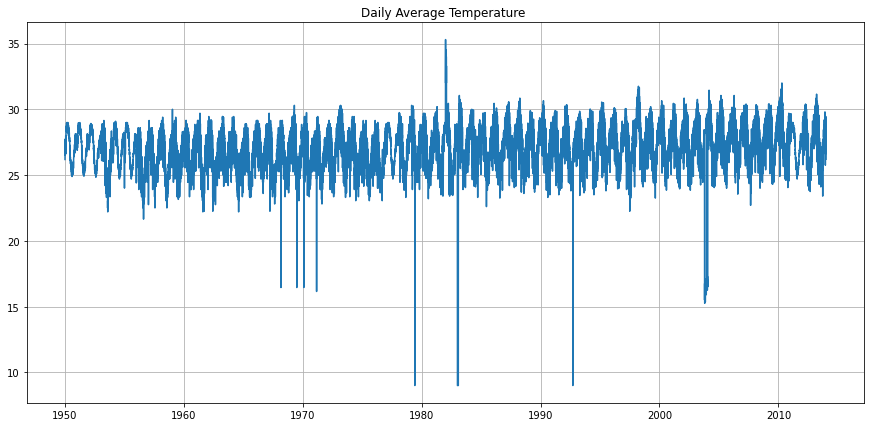

In [40]:
#visulaize data points
plt.figure(figsize=(15, 7))
plt.plot(clean['AvgTemp'])
plt.title('Daily Average Temperature ')
plt.grid(True)
plt.show()

In [53]:
#Remove outliers from data 
import scipy.stats as stats

#find Q1, Q3, and interquartile range for each column
Q1 = clean.quantile(q=.25)
Q3 = clean.quantile(q=.75)
IQR = clean.apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
data_clean = clean[~((clean < (Q1-1.5*IQR)) | (clean > (Q3+1.5*IQR))).any(axis=1)]

#find how many rows are left in the dataframe 
data_clean.shape


(23221, 1)

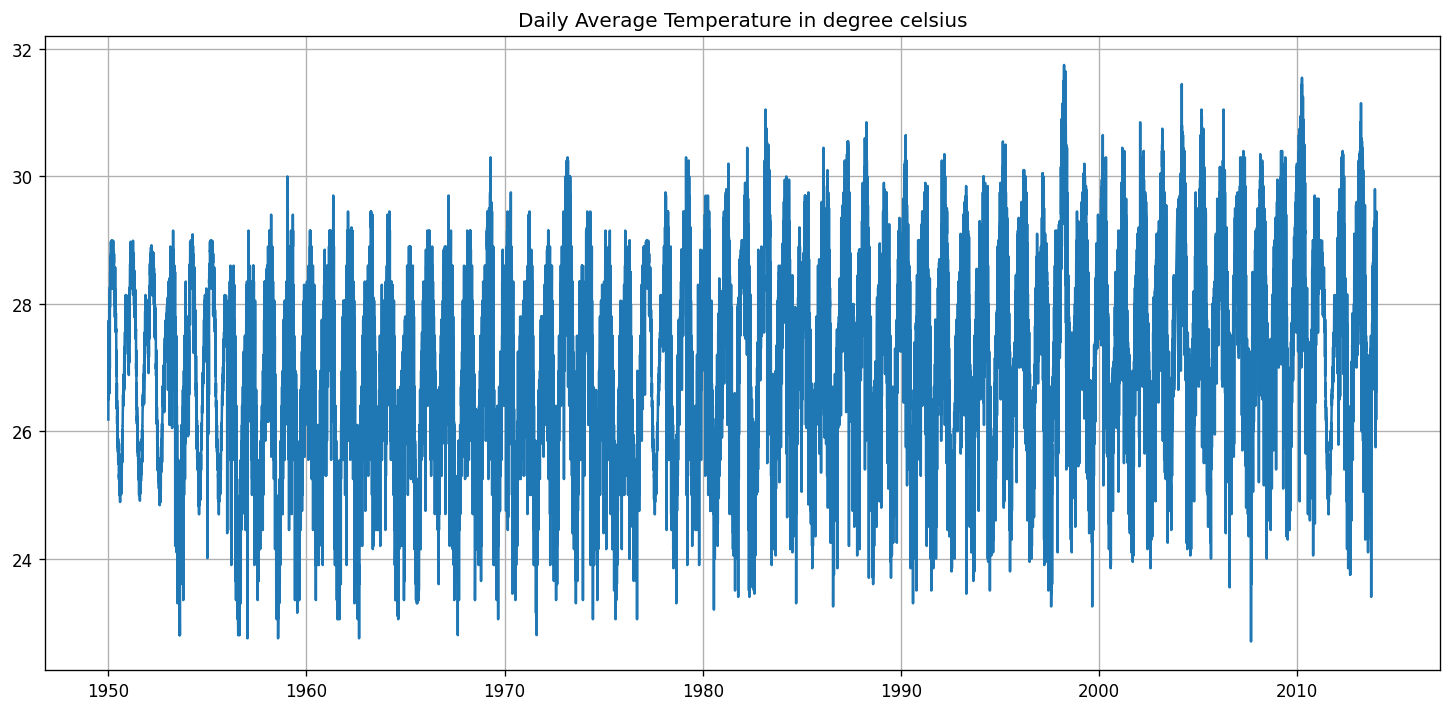

In [82]:
#visulaize data points without outliers
plt.figure(figsize=(15, 7))
plt.plot(data_clean['AvgTemp'])
plt.title('Daily Average Temperature in degree celsius')
plt.grid(True)
plt.show()

In [56]:
#use the average temperature value for each month
#The 'MS' string groups the data in buckets by start of the month
y = data_clean['AvgTemp'].resample('MS').mean()


# Decomposition of a Time Series
Decomposition of a time series can be performed by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual term. The seasonal_decompose in statsmodels implements this conveniently.

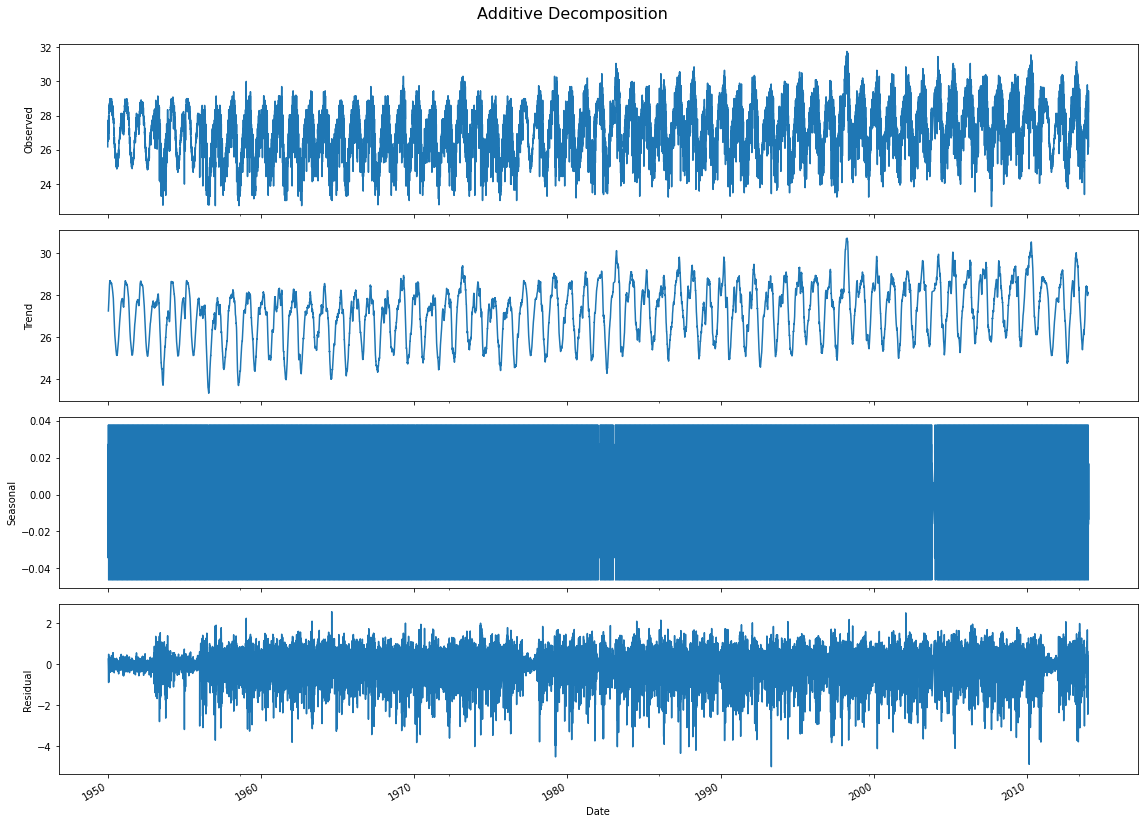

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse



# Additive Decomposition
additive_decomposition = seasonal_decompose(data_clean['AvgTemp'], model='additive', freq=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Stationary and Non-Stationary Time Series.
Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. So, the values are independent of time. Hence the statistical properties of the series like mean, variance and autocorrelation are constant over time. 

In [59]:
#test for stationarity using the augmented dickeyfuller test
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data_clean['AvgTemp'], autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical value (%s)' %key] = value
    
print(dfoutput) #p-value is less than 0.05 hence data is stationary

Test Statistic                -1.231280e+01
p-value                        7.029587e-23
Lags Used                      4.700000e+01
Number of Observations Used    2.317300e+04
Critical value (1%)           -3.430632e+00
Critical value (5%)           -2.861665e+00
Critical value (10%)          -2.566836e+00
dtype: float64


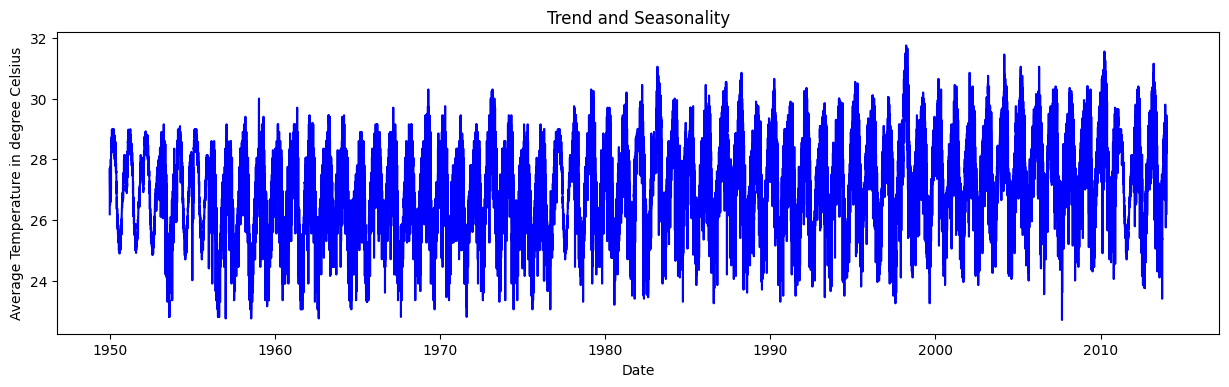

In [81]:
#check for seasonality and trend
def plot_df(df, title="", xlabel='Date', ylabel='Average Temperature in degree Celsius', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(data_clean, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(data_clean, title='Trend and Seasonality')

# Time series forecasting with ARIMA
ARIMA, which stands for Autoregressive Integrated Moving Average. ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

In [69]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [71]:
import warnings 
warnings.filterwarnings('ignore')
# use a “grid search” to find the optimal set of parameters that yields the best performance for our model.
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7219.258959410409
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6142.2849746514685
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1391.0524482617357
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1010.5638572989469
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1393.9738683434489
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:984.0596578442174
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1209.3679963410984
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1011.4290085712234
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6188.560704031905
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5136.362888222518
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1153.872066465418
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:815.1795710796553
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1157.3414499447472
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1485.1172970051718
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1013.8569826767568
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:816.4069198351666
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1874.2730163263493
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1494.5892236566601

lowest AIC scorre: ARIMA(1, 0, 1)x(1, 0, 1, 12)

In [72]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8180      0.034     24.322      0.000       0.752       0.884
ma.L1         -0.3833      0.053     -7.267      0.000      -0.487      -0.280
ar.S.L12       1.0008   9.68e-05   1.03e+04      0.000       1.001       1.001
ma.S.L12      -1.0259      0.024    -42.429      0.000      -1.073      -0.978
sigma2         0.1218      0.007     16.564      0.000       0.107       0.136


The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower than 0.05, so it is reasonable to retain all of them in our model.

<function matplotlib.pyplot.show>

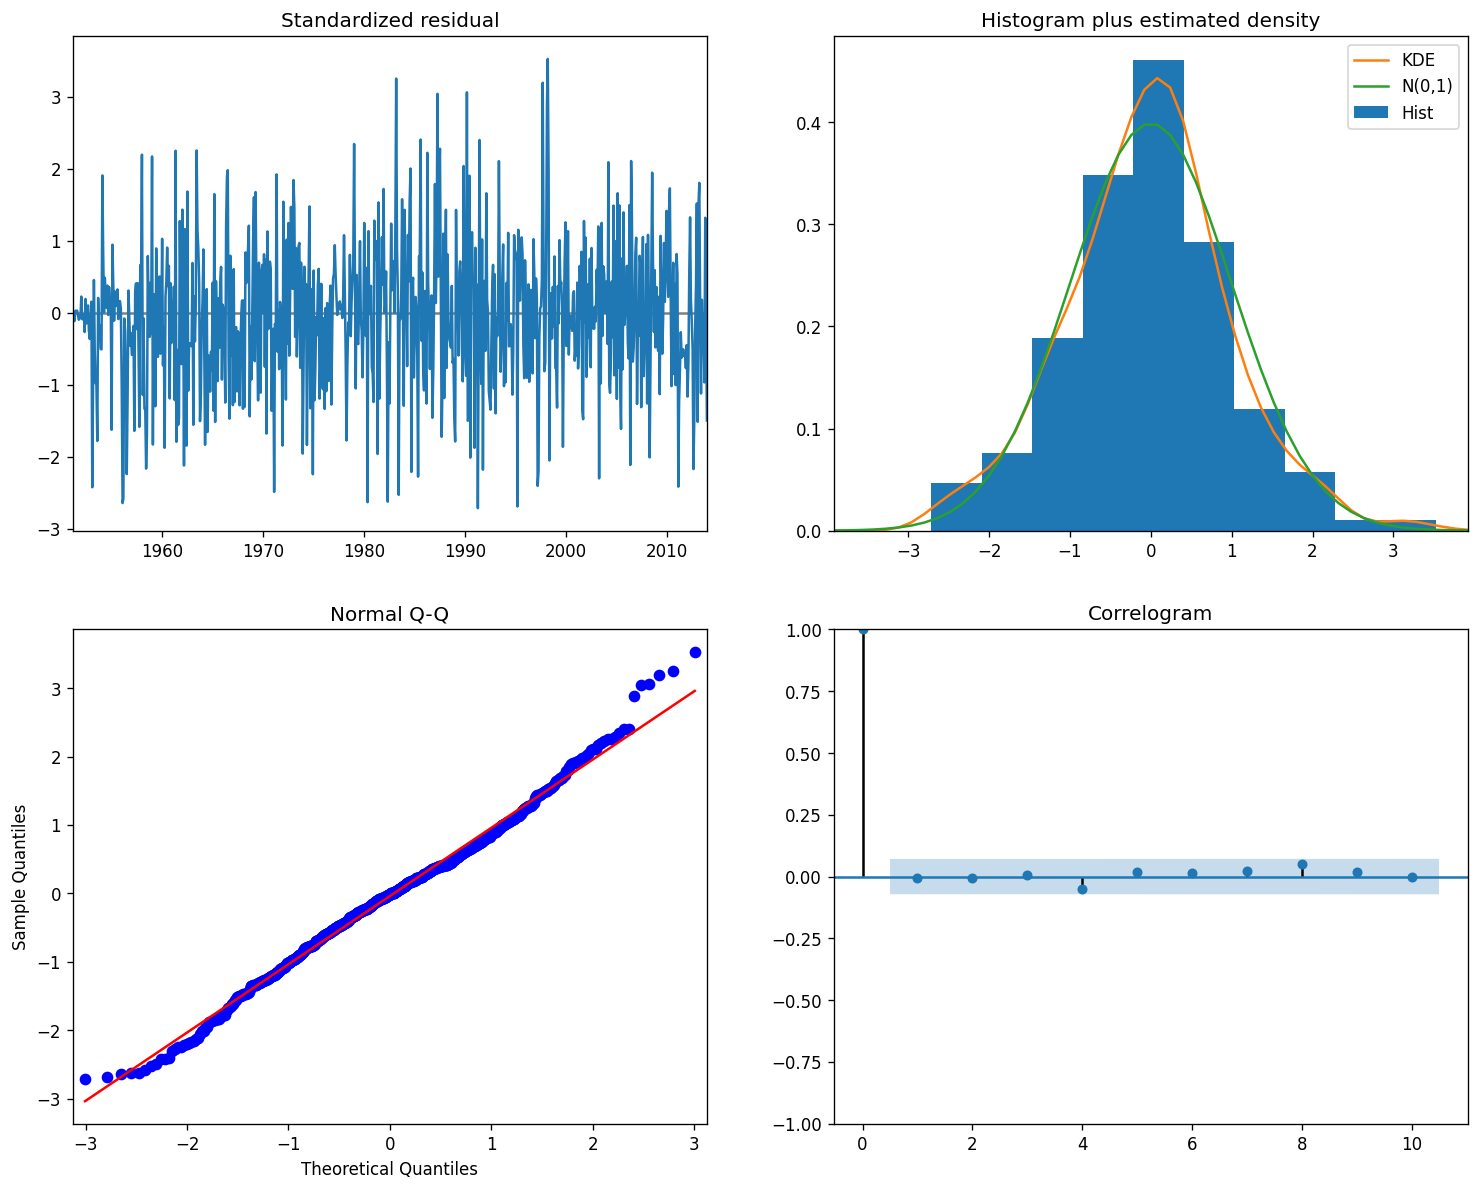

In [73]:
results.plot_diagnostics(figsize=(15, 12))
plt.show

Model diagnostics suggests that the model residuals are normally distributed.

# Validating Forecasts

In [74]:
#The code below requires the forecasts to start at January 1998.
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

#plot the real and forecasted values of theAvgTemp to assess how well the model performed.



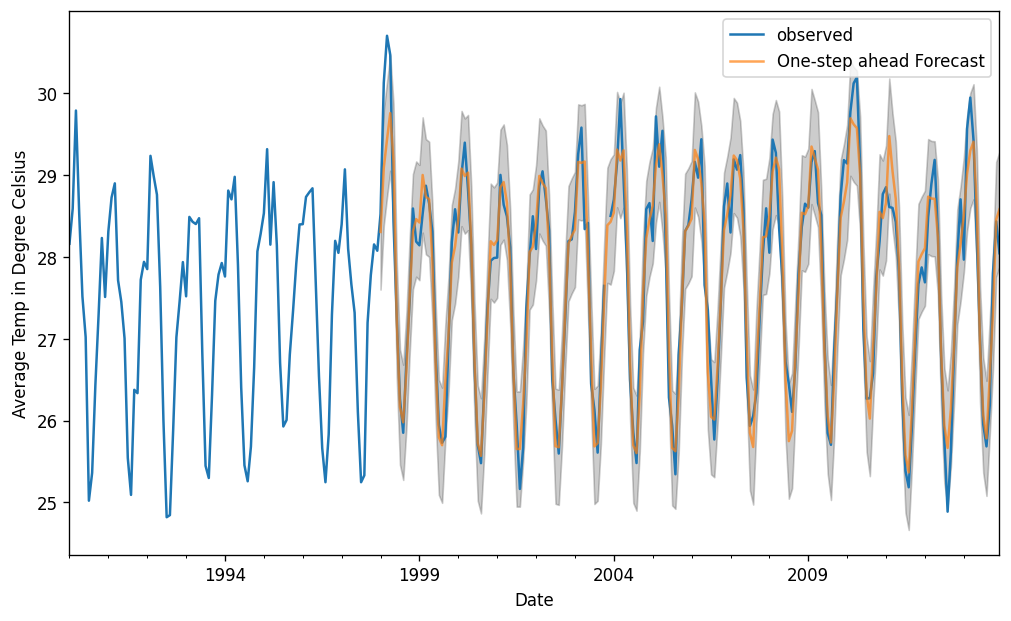

In [80]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Average Temp in Degree Celsius')
plt.legend()

plt.show()

In [76]:
#check the MSE 
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.12


The MSE of the one-step ahead forecasts yields a value of 0.12. A MSE of 0 would indicate that the estimator is predicting observations of the parameter with perfect accuracy.

In [77]:
#dynamic forecasts and confidence intervals from January 1998 onwards.
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

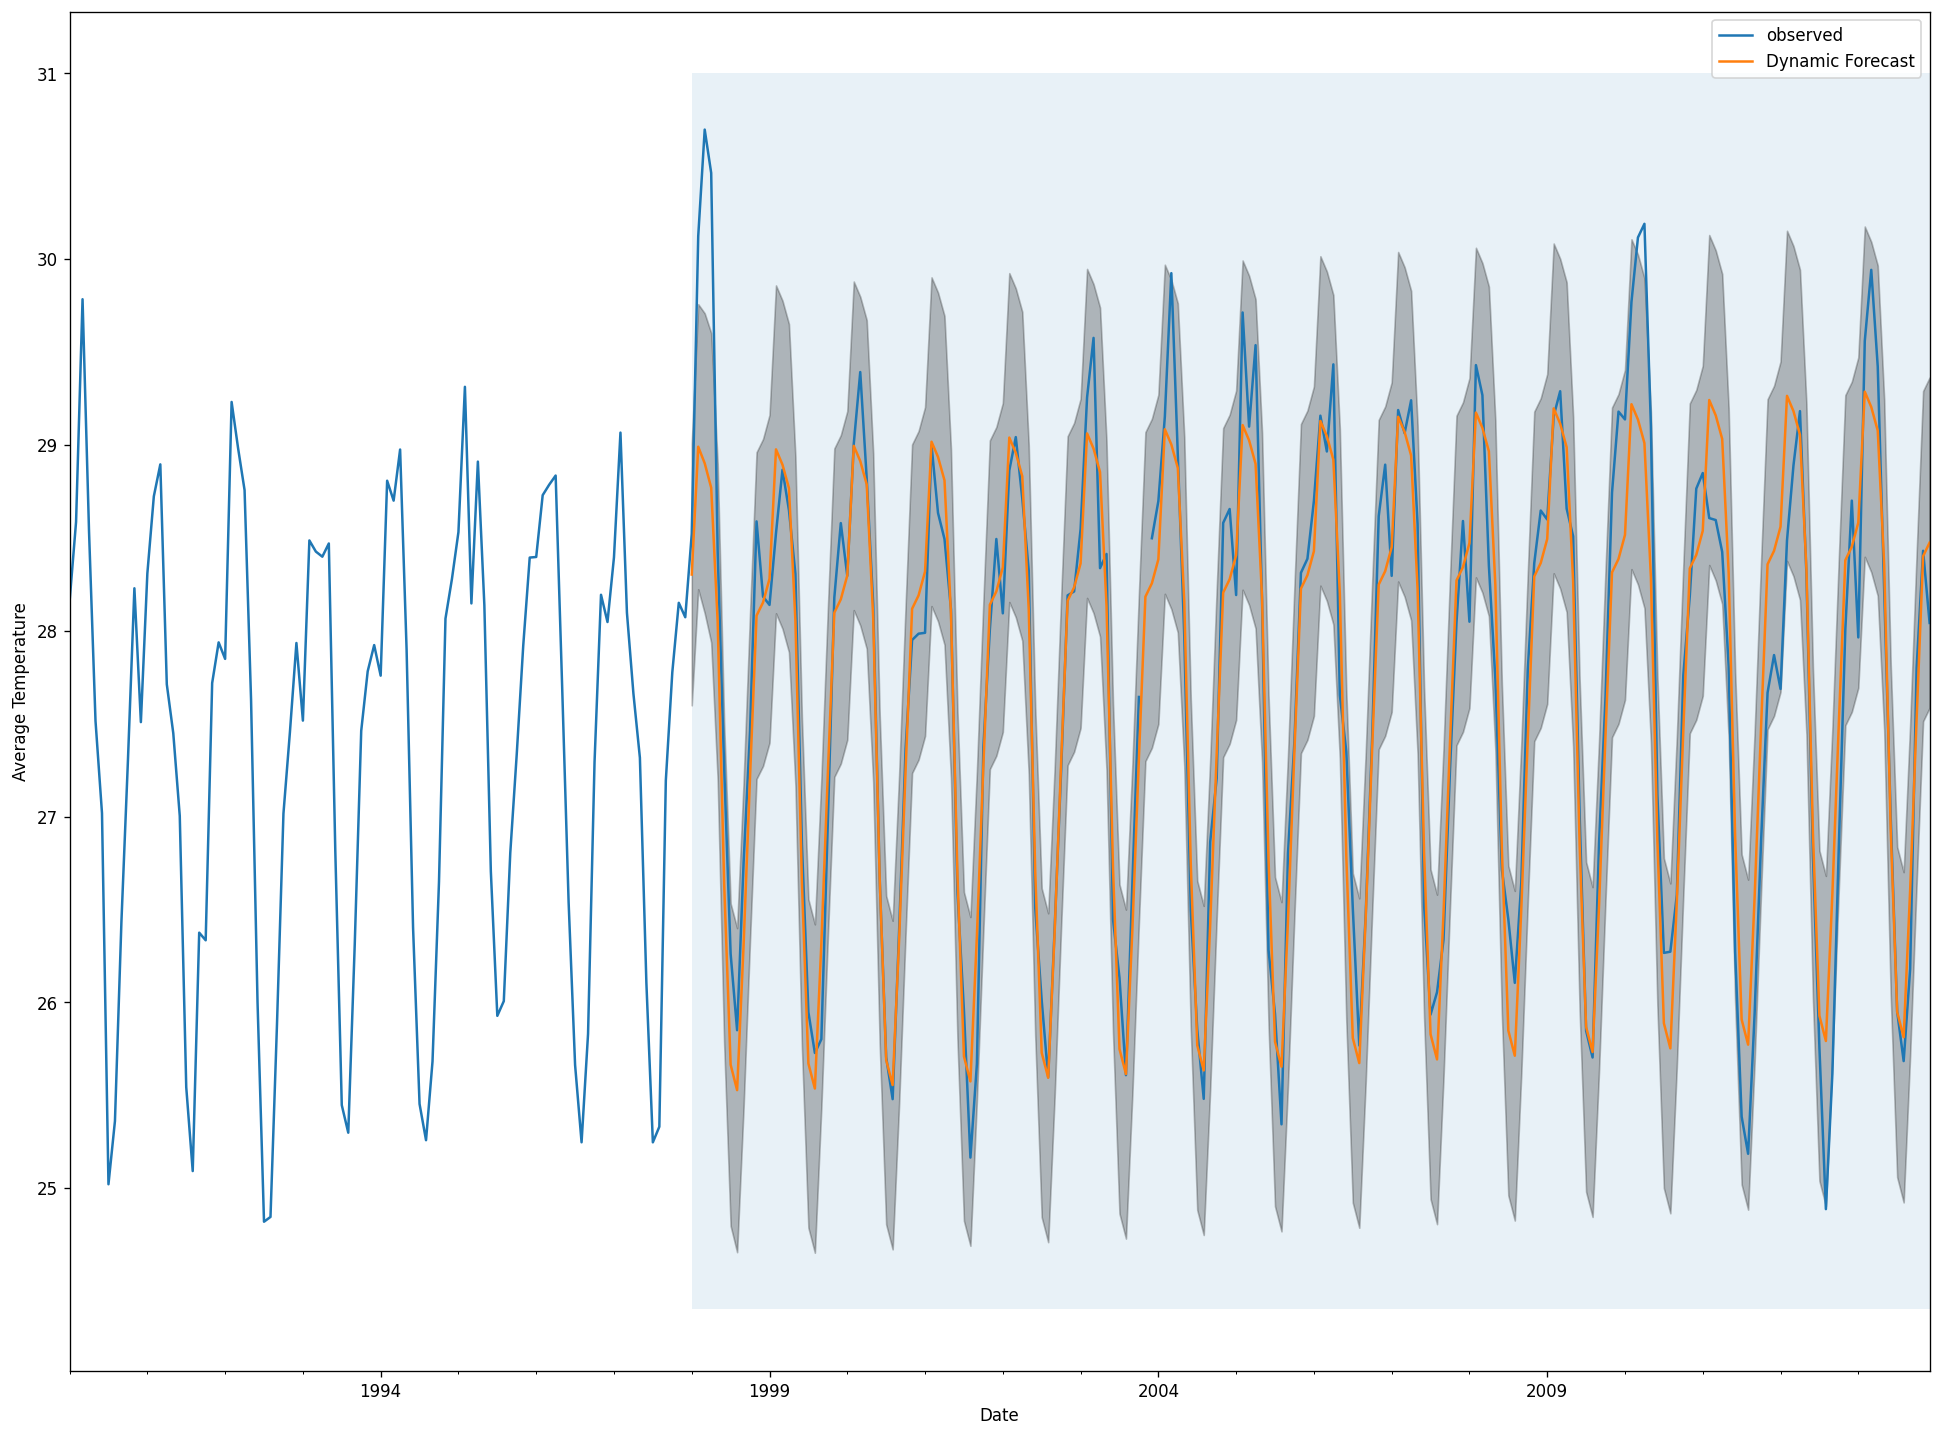

In [79]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature in degree Celsius')

plt.legend()
plt.show()

In [83]:
#Mean squared error of dynamic forecast:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.18


The MSE of dynamic forecast yields a value of 0.18

# Predictions

In [87]:
# Get forecast 300 steps ahead in future
pred_uc = results.get_forecast(steps=300)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

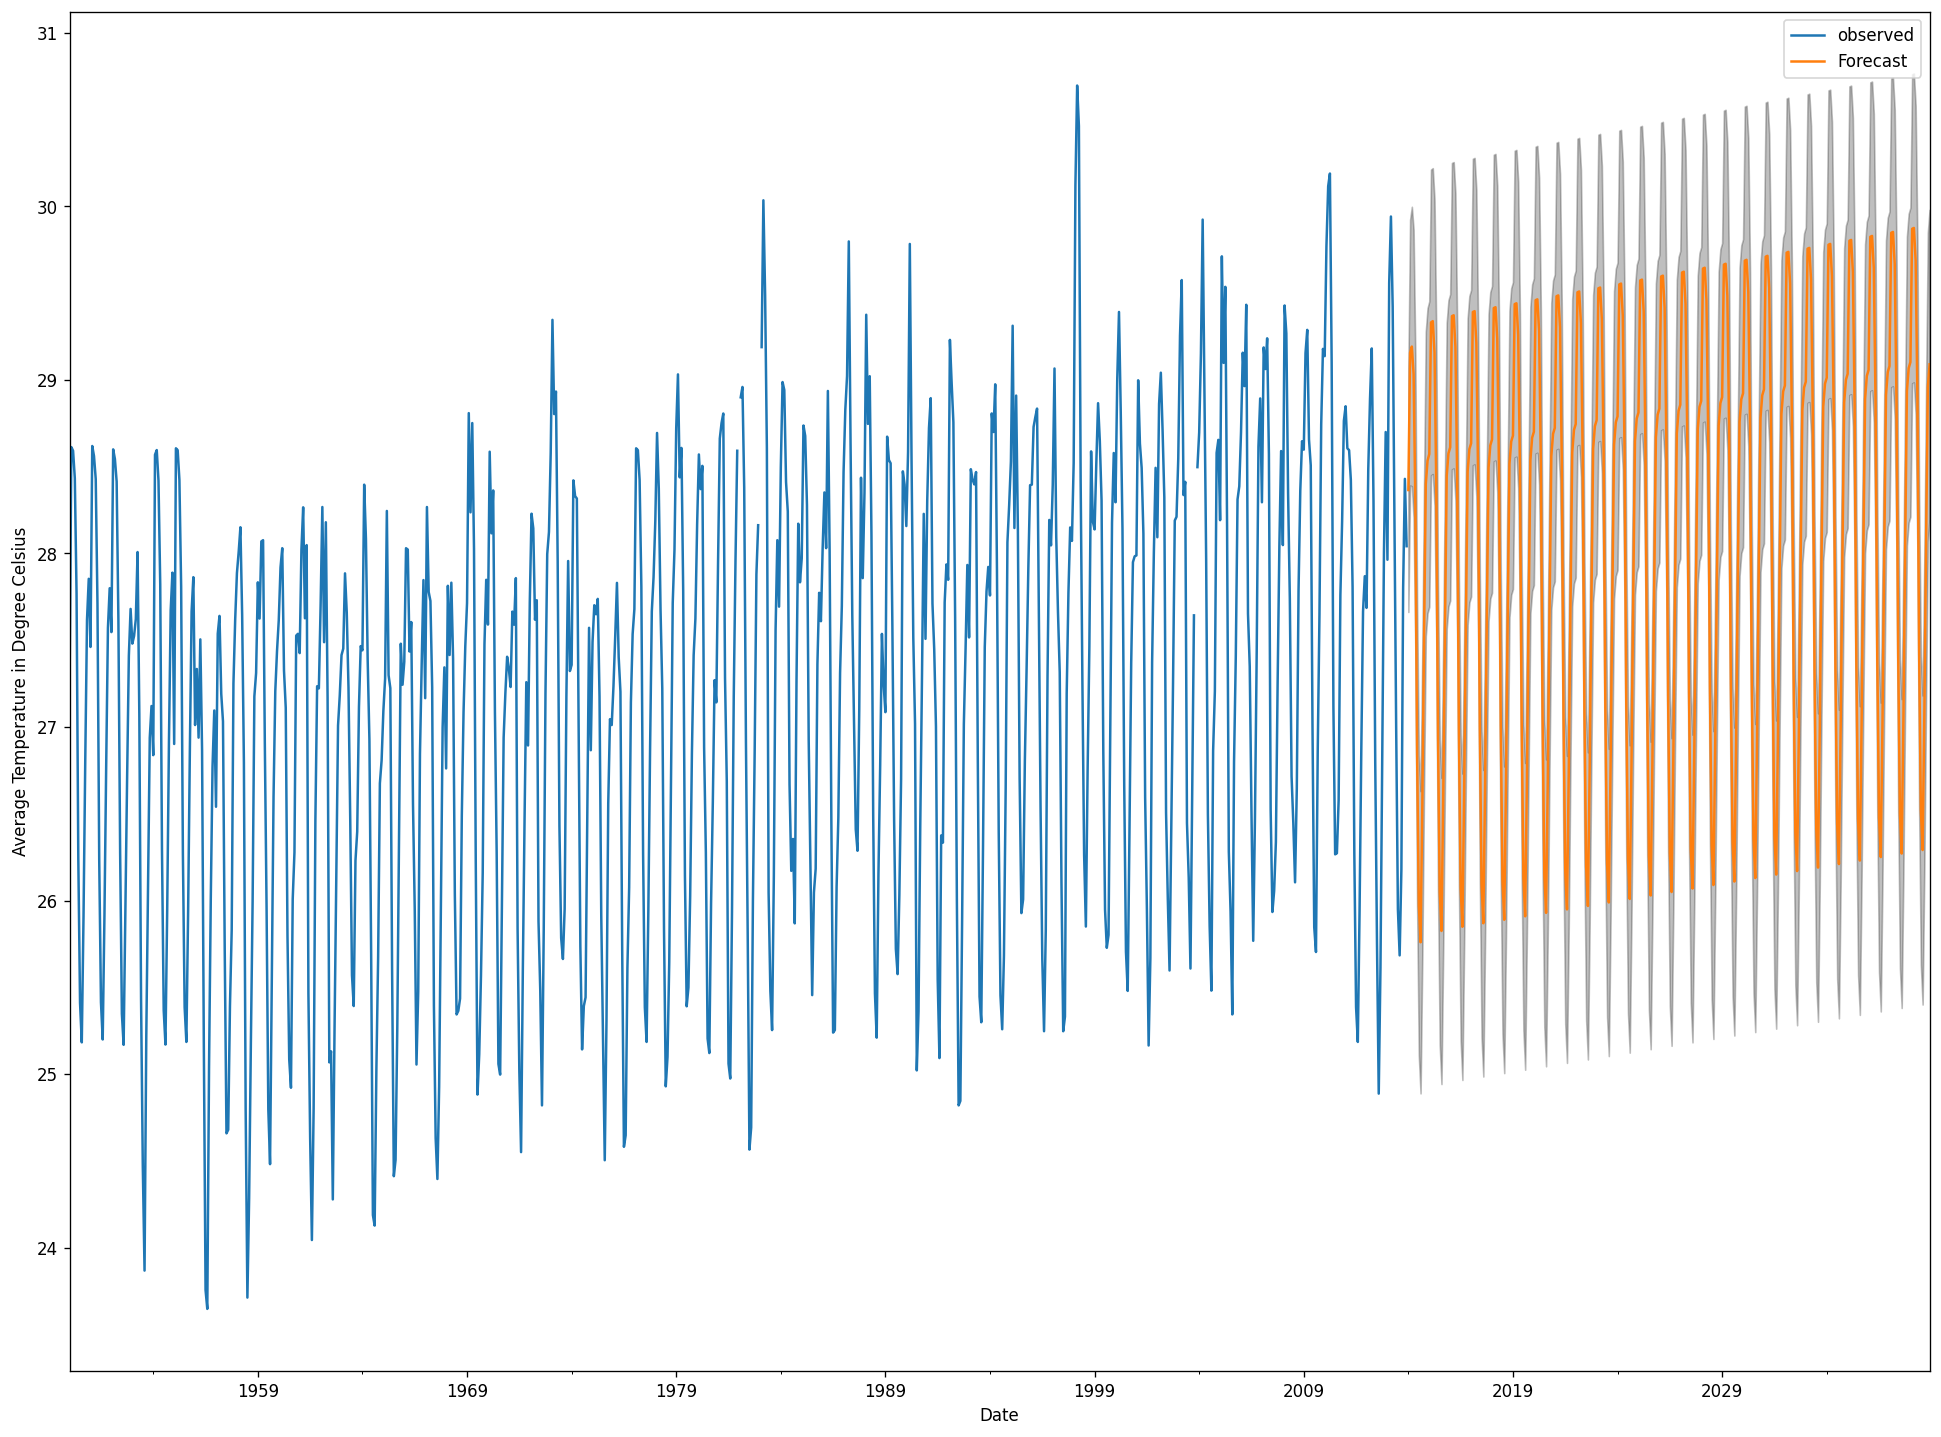

In [88]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature in Degree Celsius')

plt.legend()
plt.show()

From the above graph, we calculated the future predictions till 2029. The greyed out area is the confidence interval. This means that the predictions will not cross that area. An upward trend is observed, which corresponds with rising global temperatures worldwide